In [1]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset

import pandas, numpy, random
import matplotlib.pyplot as plt

import h5py

In [2]:
# mount Drive to access data files

from google.colab import drive
drive.mount('./mount')

Mounted at ./mount


In [3]:
# check if CUDA is available
# if yes, set default tensor type to cuda

if torch.cuda.is_available():
  torch.set_default_tensor_type(torch.cuda.FloatTensor)
  print("using cuda:", torch.cuda.get_device_name(0))
  pass

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

device

using cuda: Tesla K80


device(type='cuda')

# TEST

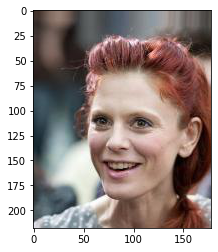

In [4]:
with h5py.File('mount/My Drive/Colab Notebooks/celeba_data/celeba_aligned_small.h5py', 'r') as file_object:
  dataset = file_object['img_align_celeba']
  image = numpy.array(dataset['1.jpg'])
  plt.imshow(image, interpolation='none')
  pass

In [5]:
image.shape

(218, 178, 3)

In [6]:
class CelebADataset(Dataset):
  def __init__(self, file):
    self.file_object = h5py.File(file, 'r')
    self.dataset = self.file_object['img_align_celeba']
    pass

  def __len__(self):
    return len(self.dataset)

  def __getitem__(self, index):
    if (index >= len(self.dataset)):
      raise IndexError()
    img = numpy.array(self.dataset[str(index)+'.jpg'])
    return torch.cuda.FloatTensor(img) / 255.0

  def plot_image(self, index):
    plt.imshow(numpy.array(self.dataset[str(index)+'.jpg']), interpolation='nearest')
    pass
  pass

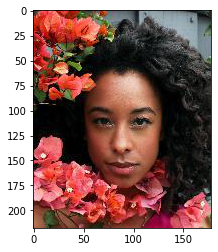

In [7]:
#dataset-object erstellen
celeba_dataset = CelebADataset('mount/My Drive/Colab Notebooks/celeba_data/celeba_aligned_small.h5py')

#dataset testen
celeba_dataset.plot_image(43)


In [8]:
class View(nn.Module):
  def __init__(self, shape):
    super().__init__()
    self.shape= shape,

  def forward(self, x):
    return x.view(*self.shape)
    

In [9]:
# discriminator class

class Discriminator(nn.Module):
    
    def __init__(self):
        # initialise parent pytorch class
        super().__init__()
        
        # define neural network layers
        self.model = nn.Sequential(
            View(218*178*3),

            nn.Linear(3*218*178, 100),
            #nn.Sigmoid(),
            #nn.LeakyReLU(0.02),
            nn.LeakyReLU(),

            nn.LayerNorm(100),

            nn.Linear(100, 1),
            nn.Sigmoid()
            #nn.LeakyReLU(0.02)

        )
        
        # create loss function
        #self.loss_function = nn.MSELoss()
        #S.96
        self.loss_function = nn.BCELoss()


        # create optimiser, simple stochastic gradient descent
        #self.optimiser = torch.optim.SGD(self.parameters(), lr=0.01)
        self.optimiser = torch.optim.Adam(self.parameters(), lr=0.0001)


        # counter and accumulator for progress
        self.counter = 0;
        self.progress = []

        pass
    
    
    def forward(self, inputs):
        # simply run model
        return self.model(inputs)
    
    
    def train(self, inputs, targets):
        # calculate the output of the network
        outputs = self.forward(inputs)
        
        # calculate loss
        loss = self.loss_function(outputs, targets)

        # increase counter and accumulate error every 10
        self.counter += 1;
        if (self.counter % 10 == 0):
            self.progress.append(loss.item())
            pass
        if (self.counter % 10000 == 0):
            print("counter = ", self.counter)
            pass

        # zero gradients, perform a backward pass, update weights
        self.optimiser.zero_grad()
        loss.backward()
        self.optimiser.step()

        pass
    
    
    def plot_progress(self):
        df = pandas.DataFrame(self.progress, columns=['loss'])
        #df.plot(ylim=(0, 1.0), figsize=(16,8), alpha=0.1, marker='.', grid=True, yticks=(0, 0.25, 0.5))
        df.plot(ylim=(0), figsize=(16,8), alpha=0.1, marker='.', grid=True, yticks=(0, 0.25, 0.5))

        pass
    
    pass

In [10]:
# functions to generate random data

def generate_random_image(size):
    random_data = torch.rand(size)
    return random_data


def generate_random_seed(size):
    random_data = torch.randn(size)
    return random_data

In [11]:
x =generate_random_image(2)
print(x.device)

y= generate_random_seed(2)
print(y.device)


cuda:0
cuda:0


In [12]:
%%time
D = Discriminator()
D.to(device)

for image_data_tensor in celeba_dataset:
  D.train(image_data_tensor, torch.cuda.FloatTensor([1.0]))

  D.train(generate_random_image((218*178*3)), torch.cuda.FloatTensor([0.0]))

  pass

counter =  10000
counter =  20000
counter =  30000
counter =  40000
CPU times: user 5min 37s, sys: 5.69 s, total: 5min 42s
Wall time: 5min 58s


In [13]:
# generator class

class Generator(nn.Module):
    
    def __init__(self):
        # initialise parent pytorch class
        super().__init__()
        
        # define neural network layers
        self.model = nn.Sequential(
            nn.Linear(100, 3*10*10),
            #nn.Sigmoid(),
            #nn.LeakyReLU(0.02),
            nn.LeakyReLU(),

            nn.LayerNorm(3*10*10),

            nn.Linear(3*10*10, 3*218*178),
            nn.Sigmoid(),
            #nn.LeakyReLU(0.02)
            View((218,178,3))

        )

        # create optimiser, simple stochastic gradient descent
        #self.optimiser = torch.optim.SGD(self.parameters(), lr=0.01)
        self.optimiser = torch.optim.Adam(self.parameters(), lr=0.0001)


        # counter and accumulator for progress
        self.counter = 0;
        self.progress = []
        
        pass
    
    
    def forward(self, inputs):        
        # simply run model
        return self.model(inputs)
    
    
    def train(self, D, inputs, targets):
        # calculate the output of the network
        g_output = self.forward(inputs)
        
        # pass onto Discriminator
        d_output = D.forward(g_output)
        
        # calculate error
        loss = D.loss_function(d_output, targets)

        # increase counter and accumulate error every 10
        self.counter += 1;
        if (self.counter % 10 == 0):
            self.progress.append(loss.item())
            pass

        # zero gradients, perform a backward pass, update weights
        self.optimiser.zero_grad()
        loss.backward()
        self.optimiser.step()

        pass
    
    
    def plot_progress(self):
        df = pandas.DataFrame(self.progress, columns=['loss'])
        #df.plot(ylim=(0, 1.0), figsize=(16,8), alpha=0.1, marker='.', grid=True, yticks=(0, 0.25, 0.5))
        df.plot(ylim=(0), figsize=(16,8), alpha=0.1, marker='.', grid=True, yticks=(0, 0.25, 0.5))

        pass
    
    pass

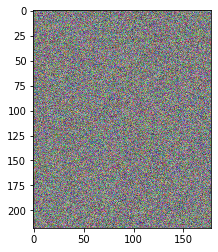

In [14]:
G = Generator()
G.to(device)

output = G.forward(generate_random_seed(100))
img = output.detach().cpu().numpy()
plt.imshow(img, interpolation='none', cmap='Blues')

In [15]:
%%time


D = Discriminator()
D.to(device)
G = Generator()
G.to(device)

epochs = 1

for epoch in range(epochs):
  print ("epoch = ", epoch + 1)

  for image_data_tensor in celeba_dataset:
    D.train(image_data_tensor, torch.cuda.FloatTensor([1.0]))

    D.train(G.forward(generate_random_seed(100)).detach(), torch.cuda.FloatTensor([0.0]))

    G.train(D, generate_random_seed(100), torch.cuda.FloatTensor([1.0]))

    pass

  pass



epoch =  1
counter =  10000
counter =  20000
counter =  30000
counter =  40000
CPU times: user 15min 6s, sys: 6.7 s, total: 15min 13s
Wall time: 15min 11s


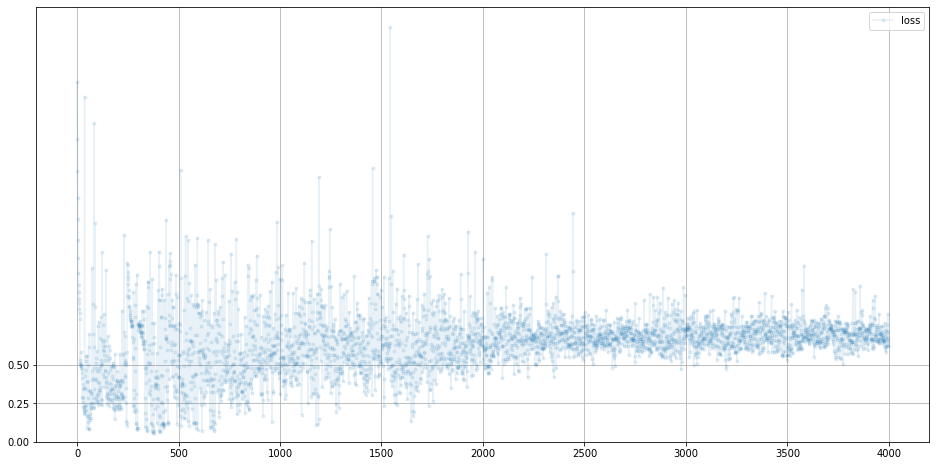

In [16]:
D.plot_progress()

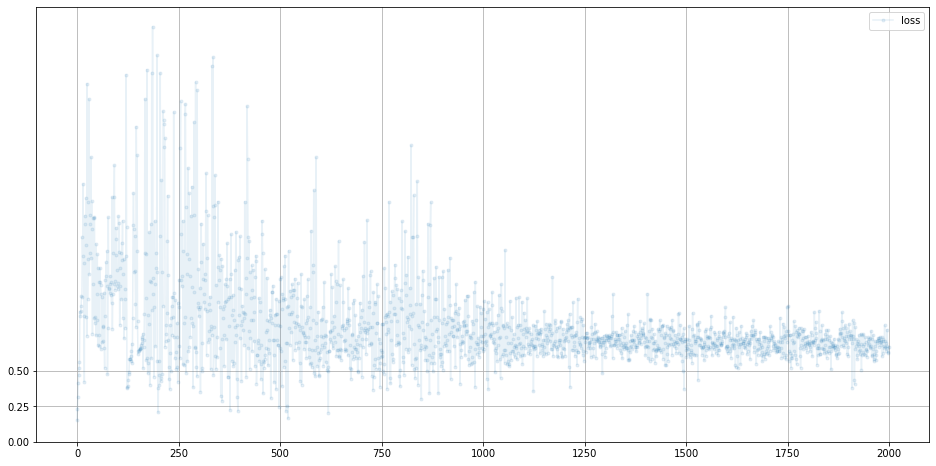

In [17]:
G.plot_progress()

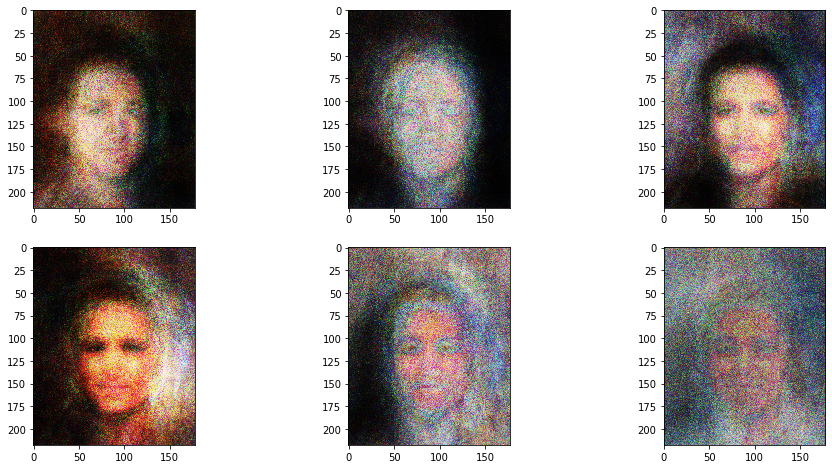

In [35]:
f, axarr = plt.subplots(2,3, figsize=(16,8))
for i in range(2):
  for j in range(3):
    output = G.forward(generate_random_seed(100))
    img =output.detach().cpu().numpy()
    axarr[i,j].imshow(img, interpolation='none', cmap='Blues')
    pass
  pass

In [29]:
torch.cuda.memory_allocated(device) / (1024*1024*1024)

0.6999902725219727

In [34]:
torch.cuda.max_memory_allocated(device) / (1024*1024*1024)

1.0935564041137695

In [33]:
print(torch.cuda.memory_summary(device, abbreviated=True))

|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  733993 KB |    1119 MB |   19249 GB |   19248 GB |
|---------------------------------------------------------------------------|
| Active memory         |  733993 KB |    1119 MB |   19249 GB |   19248 GB |
|---------------------------------------------------------------------------|
| GPU reserved memory   |    1220 MB |    1220 MB |    1220 MB |       0 B  |
|---------------------------------------------------------------